# Определение стоимости автомобилей

## Описание проекта

<b><<Описание>></b>
<br>Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
<br>
<b>Задача</b>
<br>Построить модель, которая умеет определять рыночную стоимость автомобиля. В распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
<br>
<b>Критерии, которые важны заказчику:</b>
<br>качество предсказания;
<br>время обучения модели;
<br>время предсказания модели.
<br>
<br>
<b><<Инструкция по выполнению проекта>></b>
<br>
<b>Основные шаги:</b>
<br>Загрузить данные.
<br>Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
<br>Подготовить выборки для обучения моделей.
<br>Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробывать разные гиперпараметры.
<br>Проанализировать время обучения, время предсказания и качество моделей.
<br>Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

<b>Примечания:</b>
<br>Для оценки качества моделей нужно применить метрику RMSE.
<br>Значение метрики RMSE должно быть меньше 2500.
<br>Модель градиентного бустинга может долго обучаться, поэтому можно изменить у неё только два-три параметра.
<br>
<br>
<b><<Описание данных>></b>
<br>
<b>Данные находятся в файле autos.csv.</b>
<br>
<b>Признаки:</b>
<br>DateCrawled — дата скачивания анкеты из базы
<br>VehicleType — тип автомобильного кузова
<br>RegistrationYear — год регистрации автомобиля
<br>Gearbox — тип коробки передач
<br>Power — мощность (л. с.)
<br>Model — модель автомобиля
<br>Kilometer — пробег (км)
<br>RegistrationMonth — месяц регистрации автомобиля
<br>FuelType — тип топлива
<br>Brand — марка автомобиля
<br>Repaired — была машина в ремонте или нет
<br>DateCreated — дата создания анкеты
<br>NumberOfPictures — количество фотографий автомобиля
<br>PostalCode — почтовый индекс владельца анкеты (пользователя)
<br>LastSeen — дата последней активности пользователя
<br>
<b>Целевой признак:</b>
<br>Price — цена (евро)

## Импорт библиотек

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Загрузка и обработка данных
import os
import pandas as pd
import numpy as np
from datetime import datetime

#Визуализация данных
from matplotlib import pyplot as plt
import seaborn as sns, numpy as np
import matplotlib.pyplot as mp

#Кодирование данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Модели
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


RANDOM_STATE = 42
line = '-'*150
import warnings
warnings.filterwarnings('ignore')

## Загрузка и изучение файла

Загружу данные. Переменную назову так-же как и называется файл.

In [4]:
data_1 = 'autos.csv'
data_2 = '/kaggle/input/autosss/autos.csv'
    
if os.path.exists(data_1):
    loading_1 = pd.read_csv(data_1)
elif os.path.exists(data_2):
    loading_1 = pd.read_csv(data_2)
else:
    print('Something is wrong')

In [5]:
autos = loading_1
autos_v2 = autos.copy()

In [6]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Далее изучу данные более детально. Выведу информацию по столбцам а так-же количество пропусков в каждом столбце и количество дубликатов.

In [7]:
object_data = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

def percentage_passes (dataset):
    print(autos.info())
    print(line)
    print('Процент пропущенных значений таблицы:')
    for col in dataset.columns:
        datcol = np.mean(dataset[col].isnull())
        print('{} - {}%'.format(col, round(datcol*100)))  
        
    print(line)
    print('Количество дубликатов -', dataset.duplicated().sum())

percentage_passes(autos)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<b>Вывод по первичному осмотру:</b>
<br>Датасет имеет:
<br>354368 - строк
<br>16 - столбцов
<br>В таблице присутствует 4 дубликата.
<br>Пропуски есть. Больше всего пропусков в столбцах:
<br>Repaired - 20%
<br>VehicleType - 11%
<br>FuelType - 9%

## Переработка ланных

<br>Начну с простого. Для начала удалю неинформативные признаки. Неинформативными считаю следующие признаки:
<br>DateCrawled — дата скачивания анкеты из базы - вряд ли такой признак способен повлиять на стоимость машины.
<br>NumberOfPictures — количество фотографий автомобиля - на цену вляет в первую очередь технические характеристики автомобиля.
<br>LastSeen — дата последней активности пользователя - активность пользователя - это дело пользователя.

In [8]:
autos = autos.drop(columns=['DateCrawled', 'NumberOfPictures','LastSeen'], axis=1)

autos.head(1)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435


Далее приведу название столбцов в удобный вид.

In [9]:
print(f'Старые названия - {autos.columns}')
print(line)

autos.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type',	'brand', 'repaired', 'date_created','postal_code']

print(f'Новые названия - {autos.columns}')

Старые названия - Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'PostalCode'],
      dtype='object')
------------------------------------------------------------------------------------------------------------------------------------------------------
Новые названия - Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'postal_code'],
      dtype='object')


Нормализую дату.

In [10]:
autos['date_created'] = pd.to_datetime(autos['date_created']).dt.date
autos['date_created'] = pd.to_datetime(autos['date_created'],  format='%Y-%m-%d')

In [11]:
autos['date_created'] = autos[('date_created')].values.astype("float64")

Удалю дубликаты.

In [12]:
autos = autos.drop_duplicates()
print('Количество дубликатов -', autos.duplicated().sum())

Количество дубликатов - 0


Проверю неявные дуликаты.

In [13]:
print(f"Неявные дубликаты столбца 'vehicle_type' - {autos['vehicle_type'].unique()}")
print(line)
print(f"Неявные дубликаты столбца 'gearbox' - {autos['gearbox'].unique()}")
print(line)
autos_model = autos.sort_values("model")
print(f"Неявные дубликаты столбца 'model' - {autos_model['model'].unique()}")
print(line)
print(f"Неявные дубликаты столбца 'fuel_type' - {autos['fuel_type'].unique()}")
print(line)
print(f"Неявные дубликаты столбца 'brand' - {autos['brand'].unique()}")
print(line)
print(f"Неявные дубликаты столбца 'repaired' - {autos['repaired'].unique()}")

Неявные дубликаты столбца 'vehicle_type' - [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
------------------------------------------------------------------------------------------------------------------------------------------------------
Неявные дубликаты столбца 'gearbox' - ['manual' 'auto' nan]
------------------------------------------------------------------------------------------------------------------------------------------------------
Неявные дубликаты столбца 'model' - ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiv

В столбце месяц регистрации есть нули, посмотрю что они означают.

In [14]:
print(f"Уникальные значения столбца 'registration_month' -  {autos['registration_month'].unique()}")
print(line)

zero = autos[autos['registration_month'] == 0]

print(f"Количество 0 в столбце 'registration_month' встречается - {zero[['registration_month']].count().sum()} раза.")
print(line)

num = zero[['registration_month']].count().sum() / autos[['registration_month']].count().sum() * 100

print("Процент который занимает число 0 -" "%.0f" % num)
print(line)

print("Количество месяцов - ",  autos['registration_month'].value_counts())

Уникальные значения столбца 'registration_month' -  [ 0  5  8  6  7 10 12 11  2  3  1  4  9]
------------------------------------------------------------------------------------------------------------------------------------------------------
Количество 0 в столбце 'registration_month' встречается - 36720 раза.
------------------------------------------------------------------------------------------------------------------------------------------------------
Процент который занимает число 0 -11
------------------------------------------------------------------------------------------------------------------------------------------------------
Количество месяцов -  registration_month
0     36720
3     33354
6     30571
4     28450
5     28267
7     26423
10    25236
12    23558
11    23466
9     23016
1     22531
8     21958
2     20625
Name: count, dtype: int64


Нулевого месяца быть не может. Тут два варианта либо это 'заглушка' либо под этим числом могли ставить первый месяц в году, этого я не узнаю. Заменю 0 на самый популярный месяц.

In [15]:
autos['registration_month'] = autos['registration_month'].replace(to_replace= 0, value= 3)

Такая-же ситуация со столбцом power.

In [16]:
zero_p = autos[autos['power'] == 0]

print(f"Количество 0 в столбце 'power' встречается - {zero_p[['power']].count().sum()} раза.")
print(line)

num = zero_p[['power']].count().sum() / autos[['power']].count().sum() * 100

print(f"Процент который занимает число 0 -" "%.0f" % num)
print(line)
print(f"Медианное значение столбца 'power' - {autos['power'].median()}")

Количество 0 в столбце 'power' встречается - 39530 раза.
------------------------------------------------------------------------------------------------------------------------------------------------------
Процент который занимает число 0 -11
------------------------------------------------------------------------------------------------------------------------------------------------------
Медианное значение столбца 'power' - 105.0


Тут я заменю 0 на медианное значение.

In [17]:
autos['power'] = autos['power'].replace(to_replace= 0, value= 105)

На первый взгляд на других столбцах нет странных данных. Но узнать точно можно будет только во время визуализации данных. Перейду к пропускам в столбцах.

In [18]:
for col in autos.columns:
        datcol = np.mean(autos[col].isnull())
        print('{} - {}%'.format(col, round(datcol*100)))

price - 0%
vehicle_type - 11%
registration_year - 0%
gearbox - 6%
power - 0%
model - 6%
kilometer - 0%
registration_month - 0%
fuel_type - 9%
brand - 0%
repaired - 20%
date_created - 0%
postal_code - 0%


Больше всего пропусков в столбце - repaired с него и начну. Так-как этот столбец только с двумя обозначениями, отсутстующие значения могут указывать на значения - no.

In [19]:
autos['repaired'] = autos['repaired'].fillna('no')

Значение тип топлива можно заполнить самым часто встречающимся значением.

In [20]:
autos['fuel_type'].value_counts()

fuel_type
petrol      210087
gasoline     95448
lpg           5121
cng            555
hybrid         228
other          201
electric        89
Name: count, dtype: int64

Логично что это бензин, им и заменю.

In [21]:
autos['fuel_type'] = autos['fuel_type'].fillna('petrol')

Из-за большого количества категориальны признаков сложно заменить чем-то пропуски в столбце model, решил удалить их.

In [22]:
autos = autos.dropna(subset=['model']) 

Так-же посмотрю можно ли заменить таким-же способом как и с топливом пропуски в gearbox.

In [23]:
autos['gearbox'].value_counts()

gearbox
manual    248348
auto       61034
Name: count, dtype: int64

Пожалуй заменю пропущенные значения на значение которое встречается чаще всего. 

In [24]:
autos['gearbox'] = autos['gearbox'].fillna('manual')

Посмотрю можно ли так-же сделать с vehicle_type.

In [25]:
autos['vehicle_type'].value_counts().head(10)

vehicle_type
sedan          85331
small          74125
wagon          60999
bus            26979
convertible    18689
coupe          14813
suv            10830
other           2766
Name: count, dtype: int64

Особо выделяющегося значения нет. Но удалять пропуски не желательно их 11%. Решено заменить пропуски на заглушку.

In [26]:
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown')

Модель так-же не буду смотреть ибо значений в этом столбце намного больше чем в остальных.

In [27]:
for col in autos.columns:
        datcol = np.mean(autos[col].isnull())
        print('{} - {}%'.format(col, round(datcol*100)))

price - 0%
vehicle_type - 0%
registration_year - 0%
gearbox - 0%
power - 0%
model - 0%
kilometer - 0%
registration_month - 0%
fuel_type - 0%
brand - 0%
repaired - 0%
date_created - 0%
postal_code - 0%


In [28]:
autos.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
dtype: int64

In [29]:
print('Количество дубликатов после обработки таблицы -', autos.duplicated().sum())

Количество дубликатов после обработки таблицы - 1407


In [30]:
autos = autos.drop_duplicates()
print('Количество дубликатов -', autos.duplicated().sum())

Количество дубликатов - 0


In [31]:
print(f"До удаления строк - {len(autos_v2)}")
print(line)
print(f"После удаления строк - {len(autos)}") 
print(line)
print(f"Строк удалено - {len(autos_v2) - len(autos)}")

date_100 = (len(autos_v2) - len(autos)) / len(autos_v2) * 100

print(line)
print(f"Датасет сократился на - " "%.2f" % date_100,"%")

До удаления строк - 354369
------------------------------------------------------------------------------------------------------------------------------------------------------
После удаления строк - 323347
------------------------------------------------------------------------------------------------------------------------------------------------------
Строк удалено - 31022
------------------------------------------------------------------------------------------------------------------------------------------------------
Датасет сократился на - 8.75 %


<b>Вывод по переработке данных:</b>
<br>Были удалены 3 столбца по следующим причинам:
<br>DateCrawled — дата скачивания анкеты из базы - вряд ли такой признак способен повлиять на стоимость машины.
<br>NumberOfPictures — количество фотографий автомобиля - на цену вляет в первую очередь технические характеристики автомобиля.
<br>LastSeen — дата последней активности пользователя - активность пользователя - это дело пользователя.
<br>Названия столбцов приведены в удобный вид.
<br>Удалены дубликаты.
<br>Неявных дубликатов не обнаружено.
<br>преобразована дата в столбце - date_created.
<br>В столбцах 'registration_month' и 'power' были заменены аномалии.
<br>Пропуски заменены.


## Исследовательский анализ данных

In [32]:
def data_analysis (variable, column):
    means = variable[column].mean()
    medians = variable[column].median()
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].axvline(x=means, color='green')
    axes[0].axvline(x=medians, color='red')
    axes[0].legend(['Среднее значение - {:.2f}'.format(means),
                    'Медианное значение - {:.2f}'.format(medians)])
    axes[0].set_title(f'Гистограмма для - {column}', fontsize=15)
    axes[0].set_ylabel('Количество', fontsize=10)
    
    sns.histplot(variable, bins=20, kde=True, ax=axes[0], x=column)
    axes[1].set_title(f'График ящик с усами для - {column}', fontsize=15)
    sns.boxplot(data=variable, ax=axes[1], y=column)
    axes[1].set_ylabel(column, fontsize=10)
    plt.show()
    
#------------------------------------------------------------------------------------------------------------------------------------
def direct_diagram(variable, column):
    display(variable[column].unique())
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=column, data=variable)
    plot.set_title(f'Рапределение по - {column}', fontsize=15)
    plot.set_xlabel('Количество', fontsize=10)
    plt.show()
    
#------------------------------------------------------------------------------------------------------------------------------------
def radial_diagram (variable, column):
    variable[column].value_counts().head(10).plot(y='subscription_type', kind='pie',figsize=(8,8), autopct='%1.1f%%')
    mp.title(f'Диаграмма для - {column}')
    mp.ylabel("")
    mp.show()

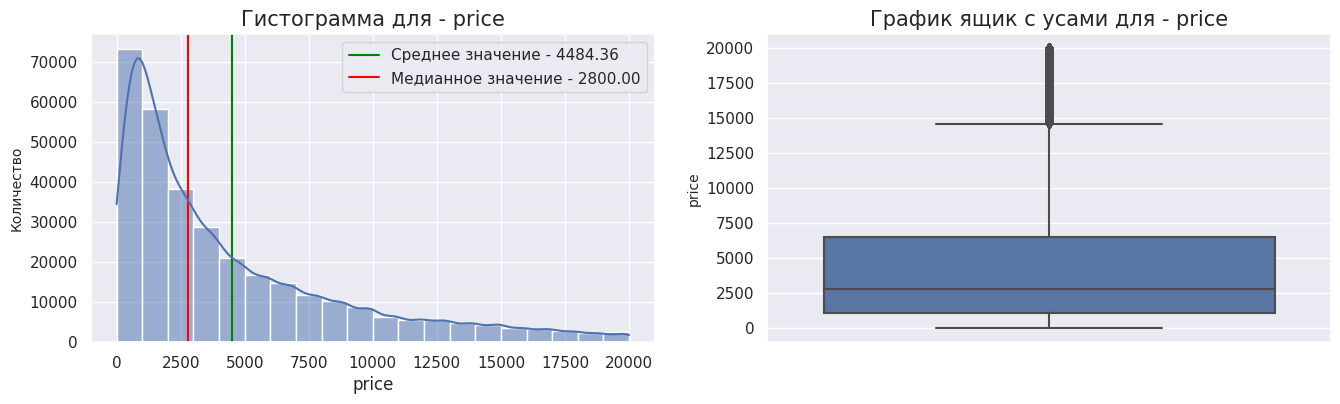

In [33]:
data_analysis(autos, 'price')

Существует очень низкие стоимости автомобилей. Заменю медианой.

In [34]:
autos.loc[autos["price"] <1000, "price"] = 2800

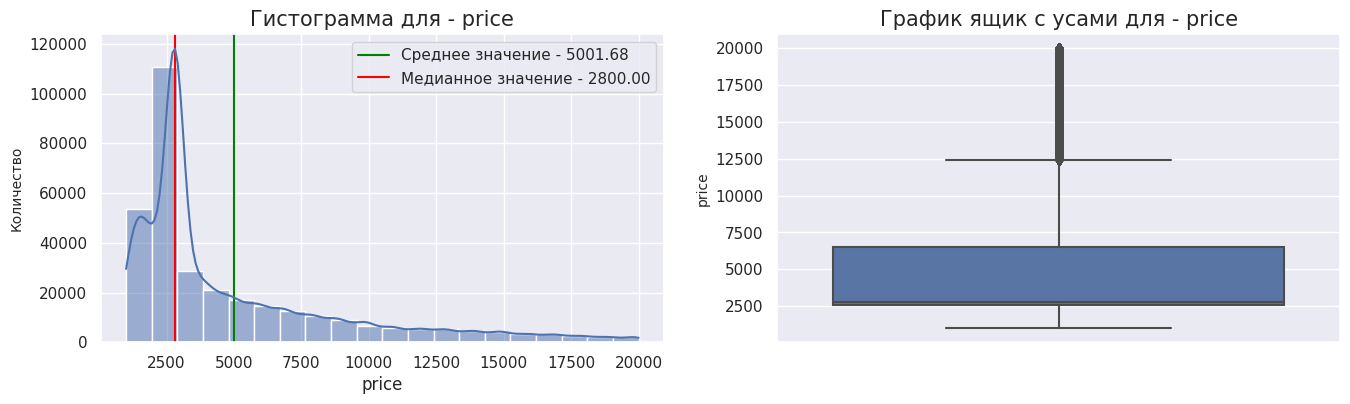

In [35]:
data_analysis(autos, 'price')

Цены большей части авто находятся в районе до 2500 евро. Есть и дорогие экземпляры стоимостью больше 10000 евро.

In [36]:
autos.price.min()

1000

array(['unknown', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

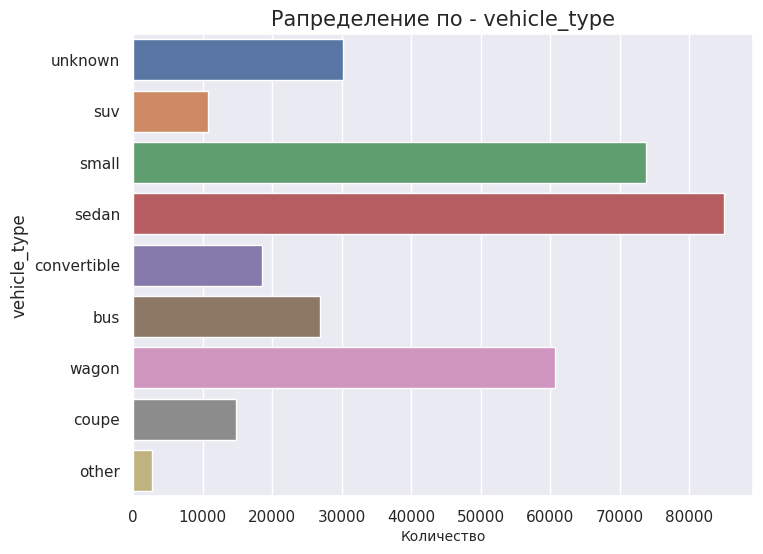

In [37]:
direct_diagram(autos, 'vehicle_type')

Топ 3 типа автомобильного кузовa -  sedan, small, wagon.

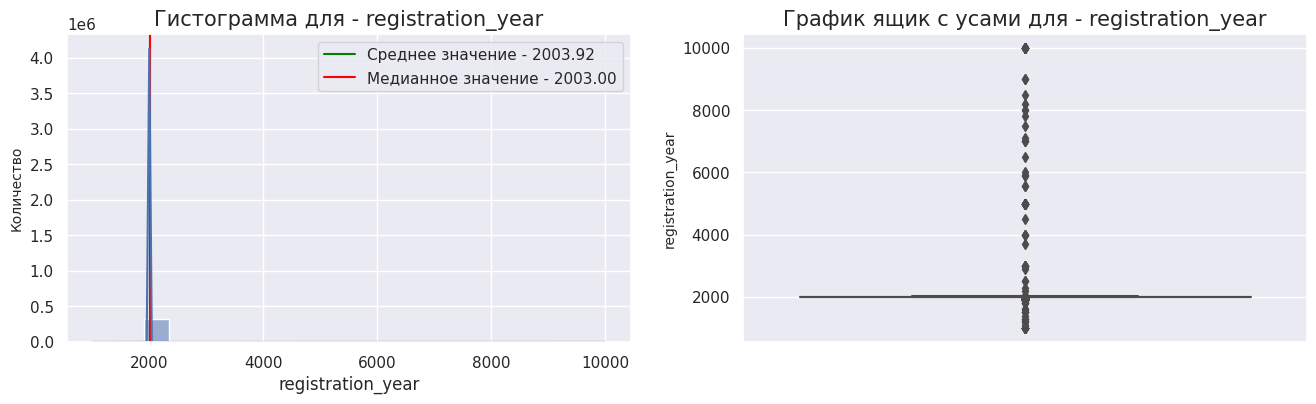

In [38]:
data_analysis(autos, 'registration_year')

Обработаю аномальные значения. Заменю значения на медиану.

In [39]:
autos_v2['DateCrawled'].max()

'2016-04-07 14:36:58'

Все данные были загружены в 2016 году.

In [40]:
autos.loc[autos["registration_year"] >= 2017, "registration_year"] = 2003

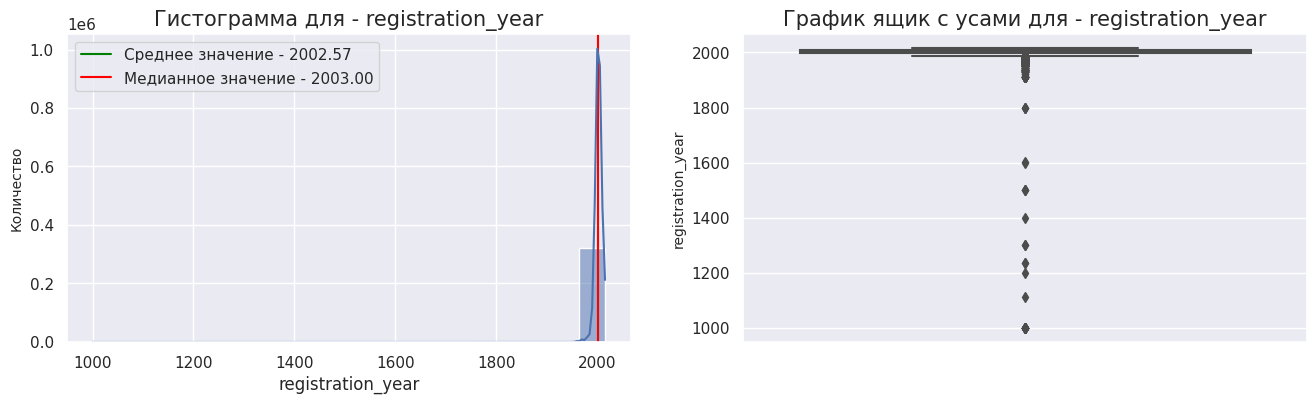

In [41]:
data_analysis(autos, 'registration_year')

Уберу так-же нереалистично старые авто. Решил минимальный год сделать 1940.

In [42]:
autos.loc[autos["registration_year"] < 1940, "registration_year"] = 2003

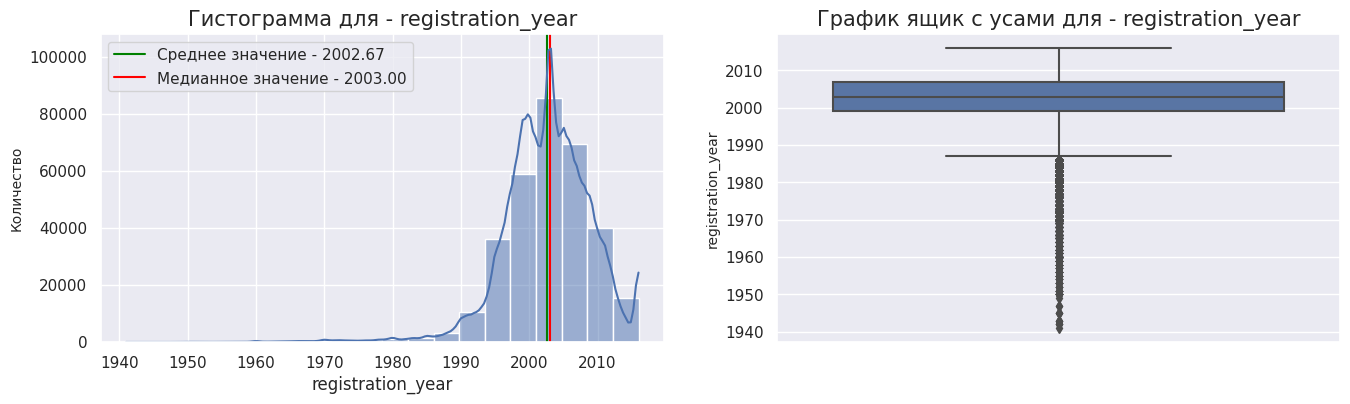

In [43]:
data_analysis(autos, 'registration_year')

В основном продают автомобили с датой регистрации 2000 - 2010 года. Пик приходится примерно на момент 2004 - 2006. Есть и более старые экземпляры которые были зарегистрированны ещё в 40-х годах. 

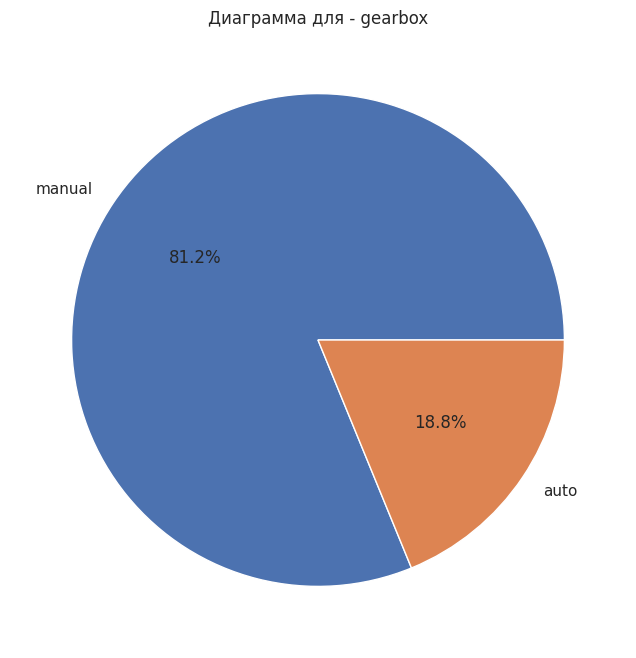

In [44]:
radial_diagram(autos, 'gearbox')

81% машин выставленных на продажу имею механическую коробку передач.

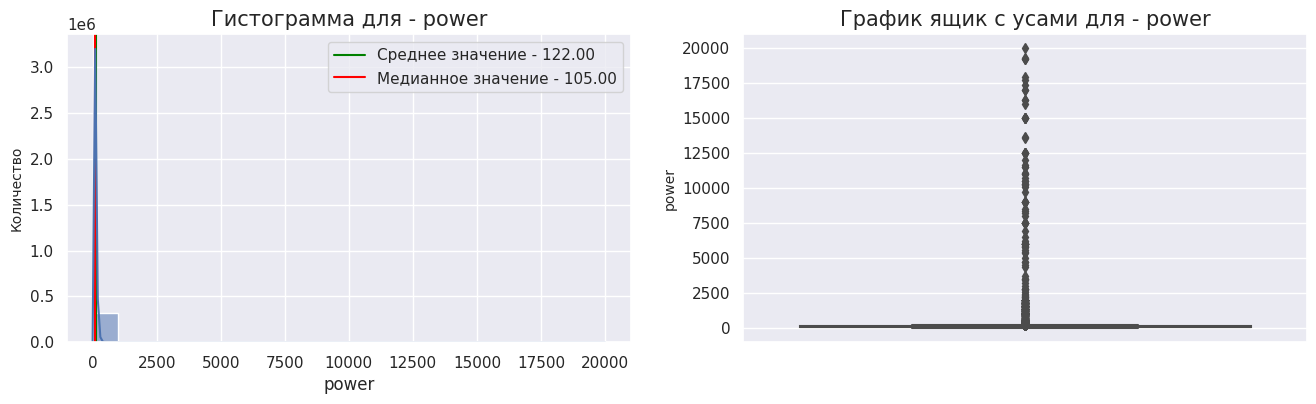

In [45]:
data_analysis(autos, 'power')

Есть авто с большими показателями мощности. Машины с показателем больше 1000 исправлю с медианным значением.

In [46]:
autos.loc[autos["power"] > 1000, "power"] = 105

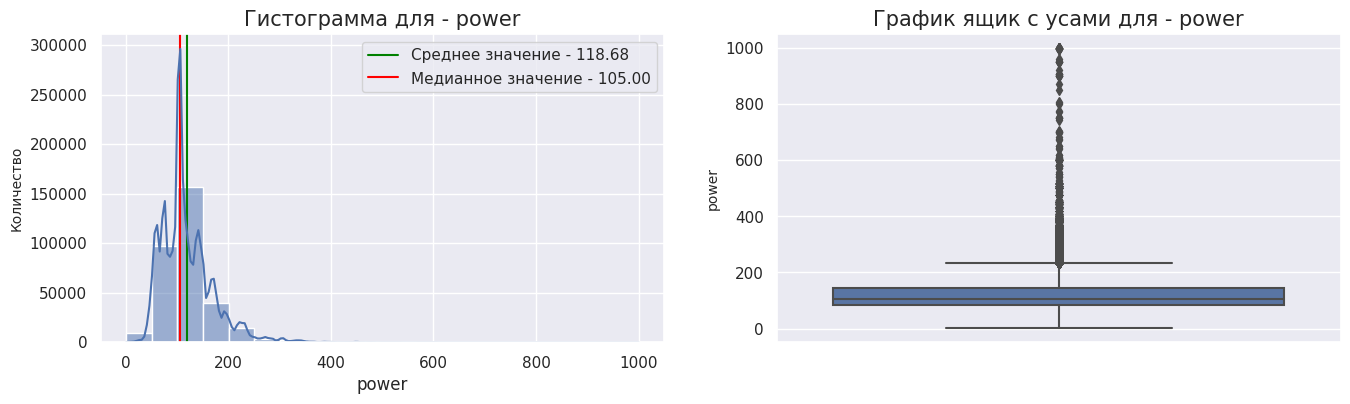

In [47]:
data_analysis(autos, 'power')

Мощность автомобилей варируется примерно от 80 до 150. Редко когда она привышает 300.

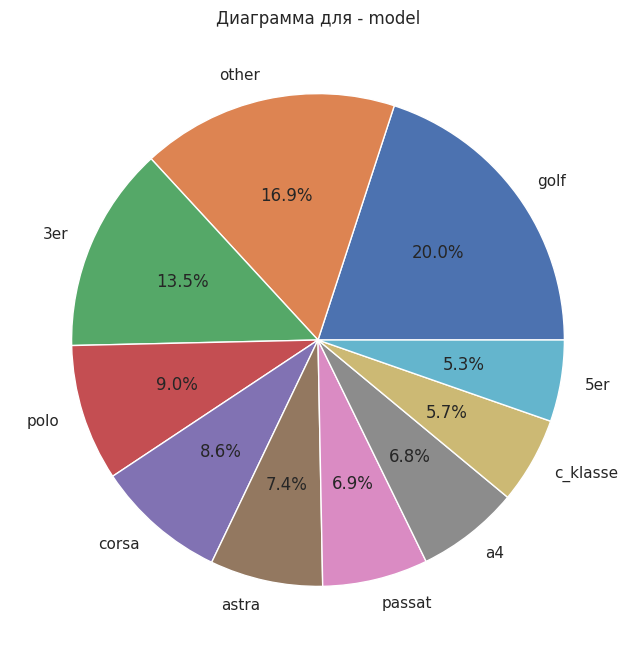

In [48]:
radial_diagram(autos, 'model')

Топ 3 модели автомобиля: golf, other, 3er.

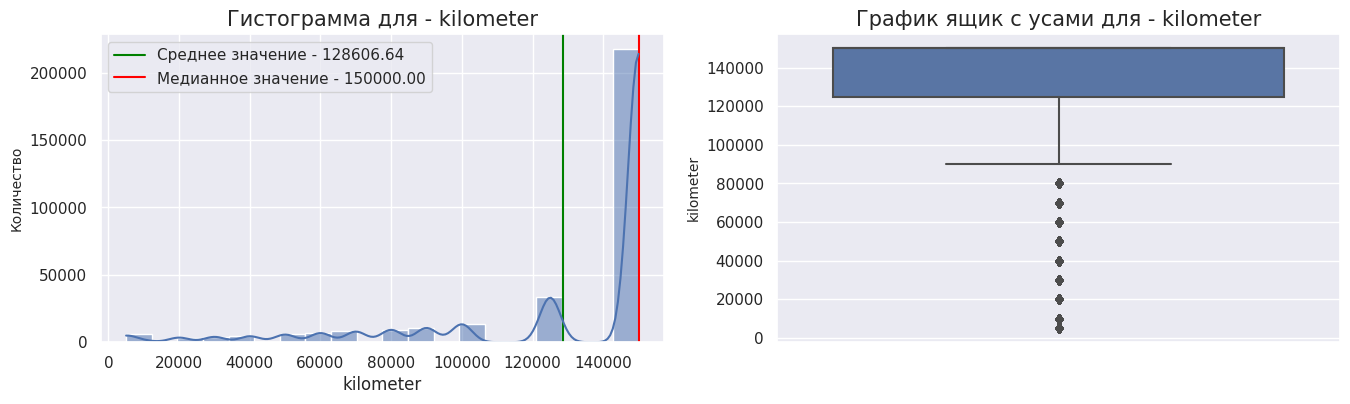

In [49]:
data_analysis(autos, 'kilometer')

По большей части пробег продаваемых автомобилей составляет свыше 120000 км.

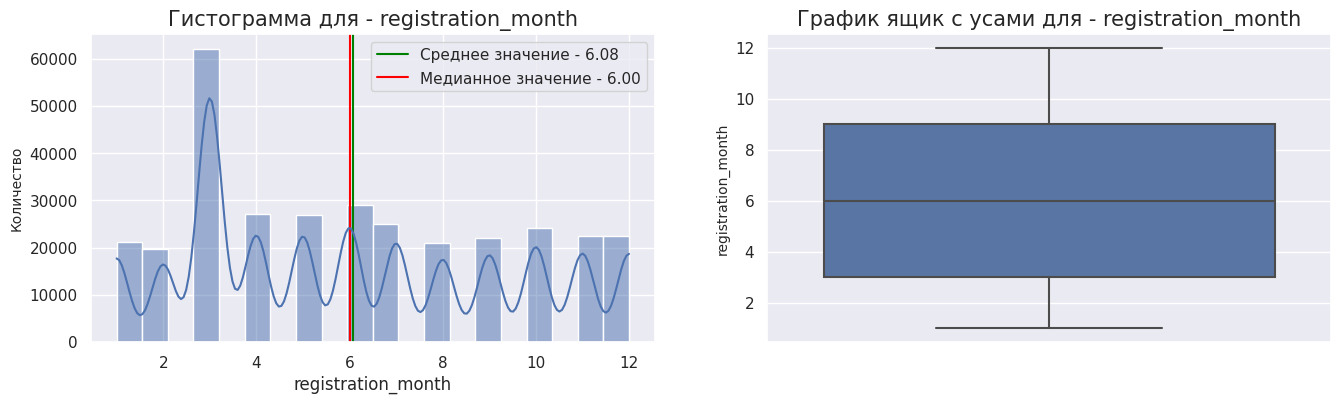

In [50]:
data_analysis(autos, 'registration_month')

В основном регистрация автомобилей происходила в первом месяце года.

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

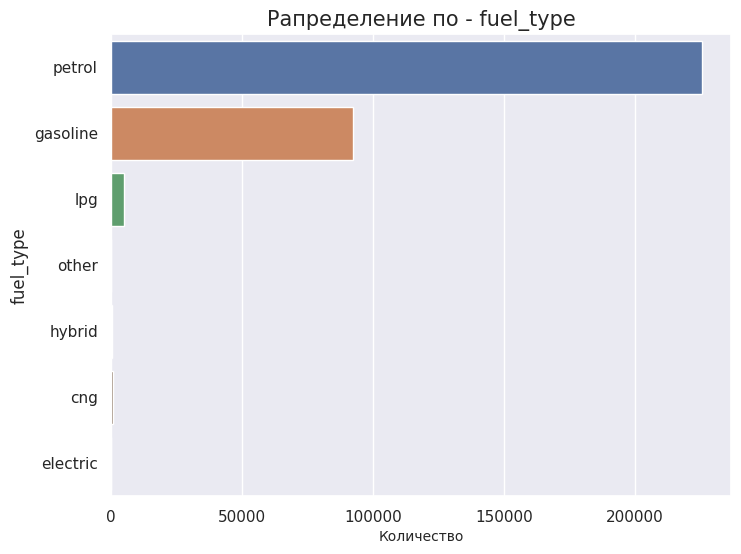

In [51]:
direct_diagram(autos, 'fuel_type')

В основном продаются машины на бензине. P.S. petrol и gasoline это одно и то-же, просто в разных странах.

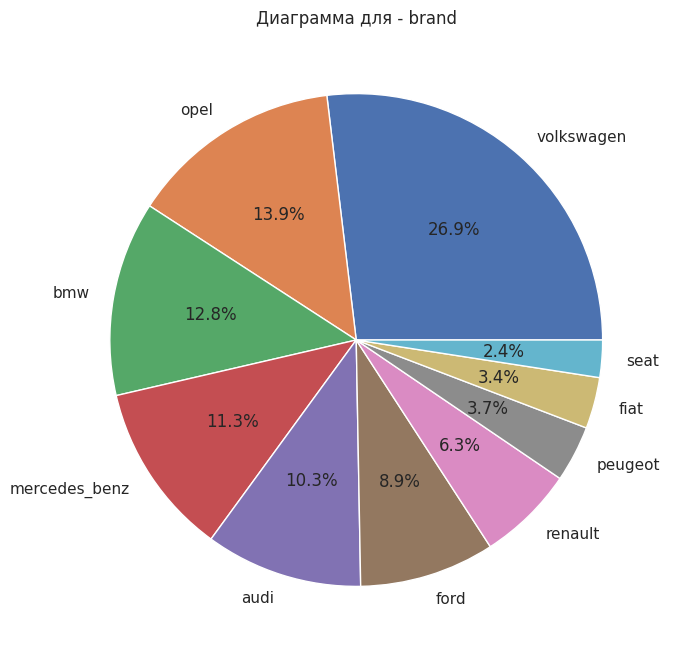

In [52]:
radial_diagram(autos, 'brand')

Топ 3 бренда: volkswagen, opel, bmw.

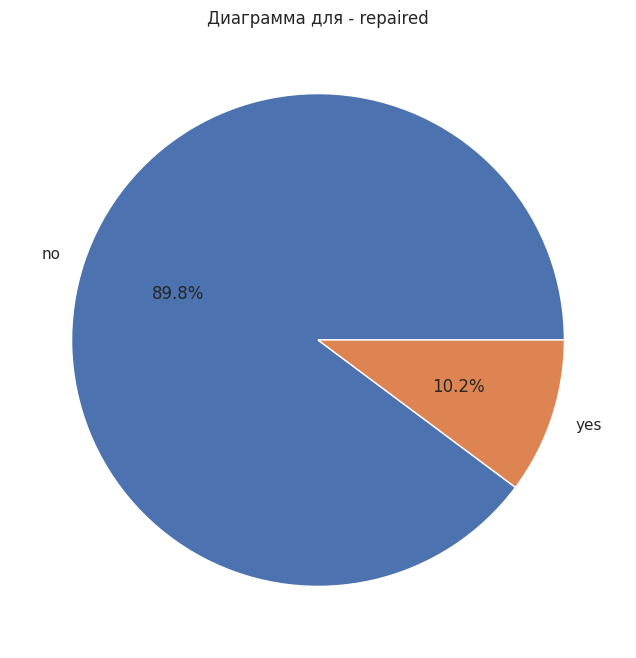

In [53]:
radial_diagram(autos, 'repaired')

Почти 90% машин не были в ремонте. 

<b>Вывод по исследовательскому анализу данных:</b>
<br>price - средняя цена  авто - 4484 евро. Больше всего автомобилей стоит около 2500 евро. Есть и дорогие экземпляры стоимостью больше 10000 евро.
<br>vehicle_type - самые популярные типы автомобильного кузовa - sedan, small, wagon.
<br>registration_year - пик приходится примерно на момент 2004 - 2006. Есть авто зарегистрированные в 40-х годах.
<br>gearbox - 81% машин имею механическую коробку передач.
<br>power - Мощность автомобилей варируется примерно от 80 до 150.
<br>model - самые популярные модели автомобиля: golf, other, 3er.
<br>kilometer - пробег большей части продаваемых автомобилей составляет свыше 120000 км.
<br>registration_month - в основном регистрация автомобилей происходила в первом месяце года.
<br>fuel_type - топливо почти всех машин - бензин .
<br>brand - самые популярные бренды: volkswagen, opel, bmw.
<br>repaired - почти 90% машин не были в ремонте.
<br>date_created - поти все автомобили выставлены на продажу в 2016 году.

## Разделение на выборки и преобразование данных

In [54]:
X = autos.drop(['price'] , axis = 1)
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE) 

print(f"Строк в тренировочном датасете - {len(X_train)}") 
print(line)
print(f"Строк в тестовом датасете - {len(X_test)}")

Строк в тренировочном датасете - 242510
------------------------------------------------------------------------------------------------------------------------------------------------------
Строк в тестовом датасете - 80837


In [55]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323347 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               323347 non-null  int64  
 1   vehicle_type        323347 non-null  object 
 2   registration_year   323347 non-null  int64  
 3   gearbox             323347 non-null  object 
 4   power               323347 non-null  int64  
 5   model               323347 non-null  object 
 6   kilometer           323347 non-null  int64  
 7   registration_month  323347 non-null  int64  
 8   fuel_type           323347 non-null  object 
 9   brand               323347 non-null  object 
 10  repaired            323347 non-null  object 
 11  date_created        323347 non-null  float64
 12  postal_code         323347 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 34.5+ MB


In [56]:
cat_col_names = ['vehicle_type','gearbox', 'model','fuel_type','brand', 'repaired']
num_col_names = ['registration_year','power', 'kilometer', 'registration_month','postal_code','date_created']

In [57]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_col_names),
        ('num', StandardScaler(), num_col_names)
    ], 
    remainder='passthrough'
) 

## Обучение моделей

### Модель GridSearchCV

In [58]:
pipe_Ridge = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', Ridge())
    ]
)

hyperparams = [{'models__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}]

ridge = GridSearchCV(pipe_Ridge, hyperparams, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

ridge.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer',
                                                                          'registration_month',
                                                                          'postal_code',
                                                                          'date_created'])])),
                                       ('models', Ridge())]),
             n_jobs=-1,
             param_grid=[{'models__solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                             'sparse_cg', 'sag', 'saga',
                                             'lbfgs']}],
             scoring='neg_mean_squared_error')

In [59]:
%%time

ridge.best_estimator_.fit(X_train, y_train)

CPU times: user 33.4 s, sys: 1.15 s, total: 34.5 s
Wall time: 11.5 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models', Ridge(solver='svd'))])

In [60]:
%%time

ridge.best_estimator_.predict(X_train)

CPU times: user 883 ms, sys: 929 ms, total: 1.81 s
Wall time: 1.75 s


array([4065.38556507, 6177.55659607, 3808.89899154, ..., 9448.81203478,
       8638.14464909,  845.02577691])

In [61]:
print("RMSE GridSearchCV -", round((-ridge.best_score_) ** 0.5))

RMSE GridSearchCV - 2645


### CatBoostRegressor

In [62]:
pipe_CatBoost = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))
    ]
)

hyperparams = [{'models__learning_rate': (0.3, 0.5),
               'models__depth': range(6, 13),
               }]

catboost = GridSearchCV(pipe_CatBoost, hyperparams, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

catboost.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer',
                                                                          'registration_month',
                                                                          'postal_code',
                                                                          'date_created'])])),
                                       ('models',
                                        <catboost.core.CatBoostRegressor object at 0x79ffc8339250>)]),
             n_jobs=-1,
             param_grid=[{'models__depth': range(6, 13),
                          'models__learning_rate': (0.3, 0.5)}],
             scoring='neg_mean_squared_error')

In [63]:
%%time

catboost.best_estimator_.fit(X_train, y_train)

CPU times: user 2min 40s, sys: 15.2 s, total: 2min 55s
Wall time: 1min 7s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models',
                 <catboost.core.CatBoostRegressor object at 0x79ffc8494450>)])

In [64]:
%%time

catboost.best_estimator_.predict(X_train)

CPU times: user 32.3 s, sys: 1.25 s, total: 33.6 s
Wall time: 31.3 s


array([2619.85514754, 1650.02232397, 2027.09470123, ..., 8308.23441063,
       7087.84526872, 2674.59619208])

In [65]:
print("RMSE CatBoostRegressor -", ((-catboost.best_score_) ** 0.5))

RMSE CatBoostRegressor - 1601.5917971633125


### DecisionTreeRegressor

In [66]:
pipe_CDT= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE, criterion='squared_error'))
    ]
)

hyperparams = [{'models__splitter': [' best', 'random']}]

decisiontreeregressor = GridSearchCV(pipe_CDT, hyperparams, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

decisiontreeregressor.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuel_type',
                                                                          'brand',
                                                                          'repaired']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'power',
                                                                          'kilometer',
                                                                          'registration_month',
                                                                          'postal_code',
                                                                          'date_created'])])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1, param_grid=[{'models__splitter': [' best', 'random']}],
             scoring='neg_mean_squared_error')

In [67]:
%%time

decisiontreeregressor.best_estimator_.fit(X_train, y_train)

CPU times: user 12.6 s, sys: 1 s, total: 13.6 s
Wall time: 13.6 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models',
                 DecisionTreeRegressor(random_state=42, splitter='random'))])

In [68]:
%%time

decisiontreeregressor.best_estimator_.predict(X_train)

CPU times: user 1.03 s, sys: 1.02 s, total: 2.06 s
Wall time: 2.05 s


array([2100., 1350., 2800., ..., 7900., 7280., 2800.])

In [69]:
print("RMSE DecisionTreeRegressor -", round((-decisiontreeregressor.best_score_) ** 0.5))

RMSE DecisionTreeRegressor - 2208


### XGBRegressor

In [70]:
pipe_xgbr= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', XGBRegressor(objective='reg:squarederror'))
    ]
)

In [71]:
%%time

pipe_xgbr.fit(X_train, y_train)

CPU times: user 33.9 s, sys: 1.1 s, total: 35 s
Wall time: 10.3 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [72]:
%%time

pipe_xgbr.predict(X_train)

CPU times: user 2.53 s, sys: 956 ms, total: 3.48 s
Wall time: 2.18 s


array([2505.663 , 1925.7794, 2236.171 , ..., 7980.5356, 7291.2314,
       2533.6006], dtype=float32)

In [73]:
xgbregressor = cross_val_score(pipe_xgbr,X_train,y_train,scoring='neg_mean_squared_error')

print("RMSE DecisionTreeRegressor -", round((-xgbregressor.mean()) ** 0.5))

RMSE DecisionTreeRegressor - 1698


### LGBMRegressor

In [74]:
pipe_lgbm= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=RANDOM_STATE))
    ]
)

pipe_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 242510, number of used features: 300
[LightGBM] [Info] Start training from score 5007.024514


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models', LGBMRegressor(num_leaves=100, random_state=42))])

In [75]:
%%time

pipe_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 242510, number of used features: 300
[LightGBM] [Info] Start training from score 5007.024514
CPU times: user 7.88 s, sys: 1.04 s, total: 8.91 s
Wall time: 5.6 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models', LGBMRegressor(num_leaves=100, random_state=42))])

In [76]:
%%time

pipe_lgbm.predict(X_train)

CPU times: user 4.39 s, sys: 905 ms, total: 5.29 s
Wall time: 3.45 s


array([2185.34223127, 2389.30811709, 2196.48067341, ..., 8319.13844504,
       7130.87918249, 2557.40348652])

In [77]:
lgbmregressor = cross_val_score(pipe_lgbm,X_train,y_train,scoring='neg_mean_squared_error')

print("RMSE LGBMRegressor -", round((-lgbmregressor.mean()) ** 0.5))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1257
[LightGBM] [Info] Number of data points in the train set: 194008, number of used features: 295
[LightGBM] [Info] Start training from score 5009.617583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 194008, number of used features: 296
[LightGBM] [Info] Start training from score 5005.163983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

### LinearRegression

In [78]:
from sklearn.linear_model import LinearRegression


In [79]:
pipe_linea= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)


pipe_linea.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models', LinearRegression())])

In [80]:
%%time

pipe_linea.fit(X_train, y_train)

CPU times: user 19 s, sys: 2.08 s, total: 21.1 s
Wall time: 9.65 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month',
                                                   'postal_code',
                                                   'date_created'])])),
                ('models', LinearRegression())])

In [81]:
%%time

pipe_linea.predict(X_train)

CPU times: user 820 ms, sys: 917 ms, total: 1.74 s
Wall time: 1.7 s


array([4060., 6172., 3804., ..., 9460., 8648.,  848.])

In [82]:
lgbmregressor = cross_val_score(pipe_linea,X_train,y_train,scoring='neg_mean_squared_error')

print("RMSE LinearRegression -", round((-lgbmregressor.mean()) ** 0.5))

RMSE LinearRegression - 2645


In [83]:
column=['RMSE модели','Скорость обучения','Скорость предсказания на train']
index = ['GridSearchCV', 'CatBoostRegressor', 'DecisionTreeRegressor', 'DecisionTreeRegressor', 'LGBMRegressor', 'LinearRegression']
data = [[2645,"12.5 s", "997 ms"],[1602, "1min 4s", "28.5 s"],[2208,"23.3 s", "1.14 s"],[1698,"5.47 s", "3.05 s"],[1652, "3.14 s", "1.7 s"],[2645, "7.96 s", "906 ms"]]

pd.DataFrame(data=data, index=index, columns=column)

,RMSE модели,Скорость обучения,Скорость предсказания на train
GridSearchCV,2645,12.5 s,997 ms
CatBoostRegressor,1602,1min 4s,28.5 s
DecisionTreeRegressor,2208,23.3 s,1.14 s
DecisionTreeRegressor,1698,5.47 s,3.05 s
LGBMRegressor,1652,3.14 s,1.7 s
LinearRegression,2645,7.96 s,906 ms


2 лучшие модели по валидационной выборке CatBoostRegressor - 1602 и LGBMRegressor - 1652.

In [84]:
%%time

y_pred = catboost.best_estimator_.predict(X_test)

mse = mean_squared_error(y_test,y_pred)

print("RMSE для CatBoostRegressor модели на тестовой выборке:", round((mse) ** 0.5))

RMSE для CatBoostRegressor модели на тестовой выборке: 1579
CPU times: user 11.3 s, sys: 472 ms, total: 11.8 s
Wall time: 11 s


Не самоый плохой результат.

In [85]:
%%time

y_pred = pipe_lgbm.predict(X_test)

mse = mean_squared_error(y_test,y_pred)

print("RMSE для LGBMRegressor модели на тестовой выборке:", round((mse) ** 0.5))

RMSE для LGBMRegressor модели на тестовой выборке: 1650
CPU times: user 1.51 s, sys: 307 ms, total: 1.81 s
Wall time: 1.19 s


<b>Общий вывод:</b>
<br>Была загружена таблица - autos. Переработаны пропуски и удалены дубликаты. Так-же были удалены не информативные столбцы. 
<br>таблица была изучена и сделаны следующие выводы:
<br>price - средняя цена  авто - 4484 евро. Больше всего автомобилей стоит около 2500 евро. Есть и дорогие экземпляры стоимостью больше 10000 евро.
<br>vehicle_type - самые популярные типы автомобильного кузовa - sedan, small, wagon.
<br>registration_year - пик приходится примерно на момент 2004 - 2006. Есть авто зарегистрированные в 40-х годах.
<br>gearbox - 81% машин имею механическую коробку передач.
<br>power - Мощность автомобилей варируется примерно от 80 до 150.
<br>model - самые популярные модели автомобиля: golf, other, 3er.
<br>kilometer - пробег большей части продаваемых автомобилей составляет свыше 120000 км.
<br>registration_month - в основном регистрация автомобилей происходила в первом месяце года.
<br>fuel_type - топливо почти всех машин - бензин .
<br>brand - самые популярные бренды: volkswagen, opel, bmw.
<br>repaired - почти 90% машин не были в ремонте.
<br>date_created - поти все автомобили выставлены на продажу в 2016 году.
<br>Были обучены 6 моделей - 'RandomForestRegressor', 'LGBMRegressor', 'XGBRegressor', 'GridSearchCV', 'DecisionTreeRegressor', 'CatBoostRegressor'.
<br>Самое быстрое обучение - LGBMRegressor.
<br>Лушая метрика RMSE - CatBoostRegressor.
<br>Лучшая скорость предсказания - GridSearchCV (RMSE у этой модели самое большое)
<br>По итогу имеется 2 лучшие модели - LGBMRegressor и CatBoostRegressor.
<br>Рекомендую выбрать LGBMRegressor. Показатели у нее чуть хуже чем у CatBoostRegressor но время обучения и предсказания знаительно меньше.